In [13]:
from mode_util_base import read_field3D
import numpy as np
from math import sin,cos,pi
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [14]:
a=np.array((1,2,3))
tuple(a)

(1, 2, 3)

In [15]:
result_dir=pathlib.Path(r"C:\Users\ykk\Desktop\cst_tools\test\data\3d_Mode_2")
efield,header=read_field3D(result_dir / 'Mode 1_e.txt',shape=(128,128,32))

Total lines:524290
EXPECTED SIZE:524290
['-241.356', '-241.356', '-329.98', '0', '0', '0', '0', '0', '0']
['-237.555', '-241.356', '-329.98', '0', '0', '0', '0', '0', '0']
['-233.754', '-241.356', '-329.98', '0', '0', '0', '0', '0', '0']
['-229.953', '-241.356', '-329.98', '0', '0', '0', '0', '0', '0']
['-226.152', '-241.356', '-329.98', '0', '0', '0', '0', '0', '0']


In [16]:
header

{'x0': -241.356,
 'y0': -241.356,
 'z0': -329.98,
 'xspace': 3.8008818897637795,
 'yspace': 3.8008818897637795,
 'zspace': 21.289032258064516,
 'xdim': 128,
 'ydim': 128,
 'zdim': 32}

In [17]:
def grid(p0,dw,dh,sw,sh):
    lines=[]
    p=p0

    for i in range(sh+1):
        for j in range(sw+1):
            p=p0+(j)*dw+(i)*dh
            x,y,z=tuple(p)
            lines.append("%f %f %f\n"%(x,y,z))
    return lines
def grid_pnts(p0,dw,dh,sw,sh):
    pnt_list=[]
    for i in range(sh+1):
        for j in range(sw+1):
            p=p0+(j)*dw+(i)*dh
            pnt_list.append(p)
    return np.array(pnt_list)
def cus_planes():
    for t in range(0,180,4):
        deg=pi/180
        r=240
        half_h=320
        theta=t*deg
        width=32
        height=128
        dz=2*half_h/height
        dx=2*cos(theta)*r/width
        dy=2*sin(theta)*r/width
        p0=np.array((-cos(theta)*r,-sin(theta)*r,-half_h))
        dw=np.array((dx,dy,0))
        dh=np.array((0,0,dz))
        u=grid(p0,dw,dh,width,height)
        fp=open("../temp/theta_%d.xyz"%t,"w")
        fp.writelines(u)
        fp.close()
    return
#cus_planes()
def cut_plane_pnts(plane_width,plane_height,plane_degrees,volume_radius,volume_zheight):
    assert 0<plane_degrees<180
    theta=plane_degrees*pi/180
    dz=volume_zheight/plane_height
    dx=2*cos(theta)*volume_radius/plane_width
    dy=2*sin(theta)*volume_radius/plane_width
    start_point=np.array((-cos(theta)*volume_radius,-sin(theta)*volume_radius,-volume_zheight/2))
    dw=np.array((dx,dy,0))
    dh=np.array((0,0,dz))
    u=grid_pnts(start_point,dw,dh,plane_width,plane_height)
    return u
    


In [18]:
cut_plane_pnts(128,128,30,64,32)

array([[-55.42562584, -32.        , -16.        ],
       [-54.55960044, -31.5       , -16.        ],
       [-53.69357503, -31.        , -16.        ],
       ...,
       [ 53.69357503,  31.        ,  16.        ],
       [ 54.55960044,  31.5       ,  16.        ],
       [ 55.42562584,  32.        ,  16.        ]])

In [19]:
def readlist_as_field2D_vec(filename,width,height,type='E'):
    arr=np.zeros((width,height))
    fp=open(filename,"r")
    xl=[]
    vl=[]
    lines=fp.readlines()
    fp.close()
    lines=lines[2:]
    print(len(lines))
    totlen=width*height
    for line in lines:
        words=line.split()
        if(len(words)<2):
            break
        else:
            u=list(map(float,words))
            xl+=u[0:3]
            if type =='E':
                vl+=list(u[i] for i in (3,5,7))
            elif type =='H':
                vl+=list(u[i] for i in (4,6,8))
            else:
                raise ValueError
    
    posarr=np.array(xl[:totlen*3]).reshape(height,width,3)
    valuearr=np.array(vl[:totlen*3]).reshape(height,width,3)
    xl=np.array(xl[:totlen*3]).reshape(totlen,3)
    vl=np.array(vl[:totlen*3]).reshape(totlen,3)
    return posarr,valuearr,xl,vl

4258


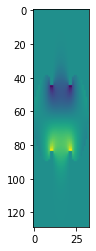

In [20]:
posarr,valuearr,xl,vl=readlist_as_field2D_vec(result_dir/"0_Mode 1_e.txt",33,129)
cut=valuearr[:,:,2]
plt.imshow(cut)

4258


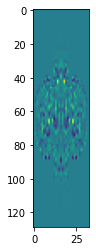

In [21]:
posarr,valuearr,_,_=readlist_as_field2D_vec(result_dir/"0_Mode 1_h.txt",33,129,"H")
plt.imshow(valuearr[:,:,0])


In [22]:
efield.shape

(128, 128, 32, 6)

In [23]:
from scipy.interpolate import interpn
x=np.linspace(-241.356,241.356,128)
y=np.linspace(-241.356,241.356,128)
z=np.linspace(-329.98,329.98,32)
points=(x,y,z)

values=efield[:,:,:]
print(efield.shape)
results=[]
for i in range(xl.shape[0]):
    for j in range(6):
        result=interpn(points,values[:,:,:,j],xl[i,:])
        results.append(result)
rv=np.array(results).reshape(129,33,6)

def savearr(xl,result,path):
    with open(path,"w") as fp:
        lines=[]
        u=xl
        v=result.reshape(result.shape[0]*result.shape[1],6)
        for i in range(u.shape[0]):
            ui=u[i]
            vi=v[i]
            line=""
            for k in range(3):
                line+="%17f" % ui[k]
            for k in range(6):
                line+="%17f" % vi[k]
            line+="\n"
            lines.append(line)
        fp.writelines(lines)
savearr(xl,rv,result_dir / "processed_0.txt")

(128, 128, 32, 6)


19848520.125061102

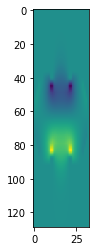

In [27]:
plt.imshow(rv[:,:,4])


def mse(a, b):
    return np.sqrt(np.sum((a-b)**2))
mse(rv[:,:,4],cut)

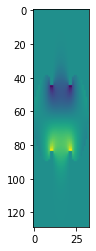

In [29]:
plt.imshow(cut)

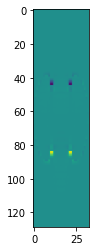

In [28]:
plt.imshow(rv[:,:,4]-cut)

In [25]:
def bilinear(poffset,v00,v01,v10,v11):
    p_x,p_y=poffset
    t_0=(v01-v00)*p_y+v00
    t_1=(v11-v10)*p_y+v10
    v_p=(t_1-t_0)*p_x+t_0
    return v_p

def border_coords(p):
    p0=np.floor(p)
    p1=np.ceil(p)
    x0,y0=p0
    x1,y1=p1
    b00=np.array((x0,y0))
    b01=np.array((x1,y0))
    b10=np.array((x0,y1))
    b11=np.array((x1,y1))
    return b00,b01,b10,b11
def values_at_matrix(coordlist,mat):
    vlist=[]
    for icoord in coordlist:
        #print(icoord)
        x,y=icoord
        vlist.append(mat[int(x),int(y)])
    return tuple(vlist)
def bilinear_full(p_coord,mat):
    print(p_coord)
    b00,b01,b10,b11=border_coords(p_coord)
    print(b00,b01,b10,b11)
    result=values_at_matrix([b00,b01,b10,b11],mat[:,:])
    v00,v01,v10,v11=result
    print(v00,v01,v10,v11)
    v_p=bilinear(p_coord-b00,v00,v01,v10,v11)
    return v_p
def nearest_neighbor(p_coord,mat):
    b00,b01,b10,b11=border_coords(p_coord)
    result=values_at_matrix([b00,b01,b10,b11],mat[:,:])
    v00,v01,v10,v11=result
    v_p=v00
    return v_p

(128, 128, 32)
[64. 64.]
[64. 64.] [64. 64.] [64. 64.] [64. 64.]
-60049.5 -60049.5 -60049.5 -60049.5
[64. 64.]
[64. 64.] [64. 64.] [64. 64.] [64. 64.]
-60049.5 -60049.5 -60049.5 -60049.5
[63.29289322 64.70710678]
[63. 64.] [64. 64.] [63. 65.] [64. 65.]
-60049.5 -60049.5 -59324.0 -59324.0
[64.70710678 63.29289322]
[64. 63.] [65. 63.] [64. 64.] [65. 64.]
-60049.5 -59397.3 -60049.5 -59397.3
[62.58578644 65.41421356]
[62. 65.] [63. 65.] [62. 66.] [63. 66.]
-58847.1 -59324.0 -57758.6 -58189.2
[65.41421356 62.58578644]
[65. 62.] [66. 62.] [65. 63.] [66. 63.]
-58847.1 -57840.7 -59397.3 -58314.8
[61.87867966 66.12132034]
[61. 66.] [62. 66.] [61. 67.] [62. 67.]
-57016.3 -57758.6 -55554.8 -56309.7
[66.12132034 61.87867966]
[66. 61.] [67. 61.] [66. 62.] [67. 62.]
-57016.3 -55685.0 -57840.7 -56437.9
[61.17157288 66.82842712]
[61. 66.] [62. 66.] [61. 67.] [62. 67.]
-57016.3 -57758.6 -55554.8 -56309.7
[66.82842712 61.17157288]
[66. 61.] [67. 61.] [66. 62.] [67. 62.]
-57016.3 -55685.0 -57840.7 -56437

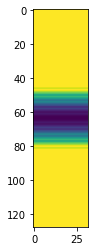

In [26]:
umatrix=np.ones((128,128,32,6))
umatrix=efield[:,:,:,4]
print(umatrix.shape)
height=32
ishape=umatrix.shape
deg= pi / 180
theta= 45 *deg
u_vec=np.array((-sin(theta),cos(theta)))
centor=np.array((64,64))
sample_pnts=128
u_vec=u_vec*ishape[0]/sample_pnts
slice_t=np.zeros((sample_pnts,height))
h_pnts=int(sample_pnts/2)

###
for z in range(height):
    for i in range(h_pnts):
        p_t=centor+i*u_vec
        
        v_p=bilinear_full(p_t,umatrix[:,:,4])
        q_t=centor-i*u_vec
        v_q=bilinear_full(q_t,umatrix[:,:,4])
        slice_t[h_pnts+i-1,z]=v_p
        slice_t[h_pnts-i,z]=v_q

plt.imshow(slice_t) #Zfield in Z slice
    